# Interface-fitted Mesh Generator: Two Dimensions

We explain a simple mesh generator for generating an interface-fitted mesh in two dimensions. 

**Algorithm:  2D Interface-fitted Mesh Generation**

0. Generate a uniform Cartesian mesh of the box

1. Find points near the interface. 
    - cut points
    - mesh points near or on the interface
    - centers of special elements.

2. Construct a Delaunay triangulation on these points.

3. Post processing. 
    - remove triangles away from the interface
    - merge all uncut elements

Run the following example and read the code for the illustration of each step.

In [ ]:
box = [ -1, 1, -1, 1];
[node,elem,interface] = interfacemeshdoc(box,@phiheart,0.05);
showmesh(node,elem);
findedge(node,interface.edge,'all','noindex','draw');

## Generate a uniform Cartesian mesh of the box

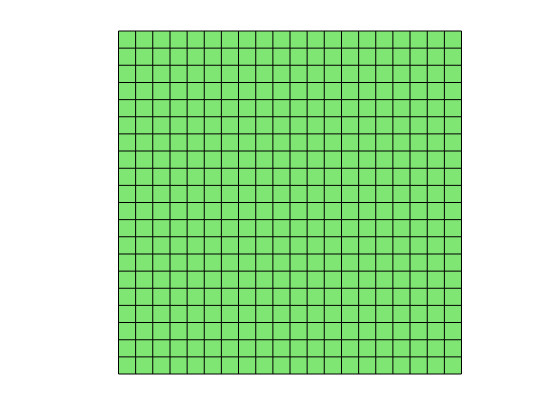

In [18]:
box = [ -1, 1, -1, 1];
h = 0.1;
[node,elem,T] = squarequadmesh(box,h);
edge = T.edge;
edge2elem = T.edge2elem;
clear T;
N = size(node,1);
NT = size(elem,1);
showmesh(node,elem);

## Find points near the interface

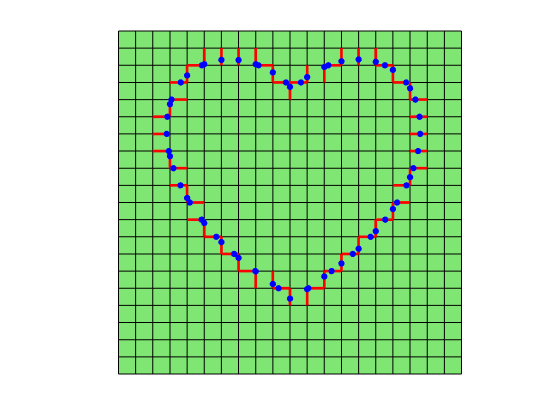

In [19]:
phi = @phiheart;
showmesh(node,elem);
hold on;

% compute the phi value at each vertex
phiValue = phi(node);
phiValue(abs(phiValue) < eps*h) = 0;  % treat nearby nodes as on the interface
vSign = sign(phiValue);
findnode(node,vSign==0);

% Find the intersection points between edges and the interface
isCutEdge = (vSign(edge(:,1)).* vSign(edge(:,2))<0);
findedge(node,edge,isCutEdge,'noindex','draw');
A = node(edge(isCutEdge,1),:);
B = node(edge(isCutEdge,2),:);
cutNode = findintersectbisect(phi,A,B);
Ncut = size(cutNode, 1);
vSign(N+1:N+Ncut) = 0;
findnode(cutNode,'all','noindex','color','b','MarkerSize',12);

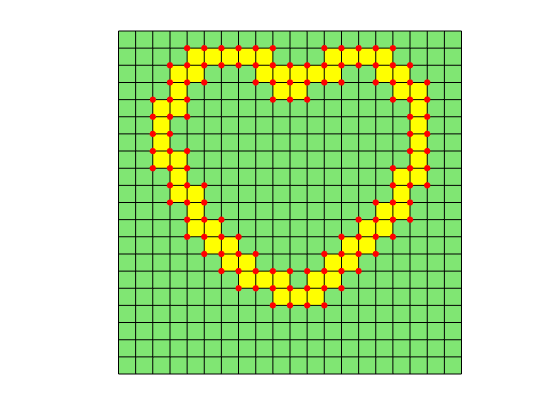

In [20]:
showmesh(node,elem);
hold on;
% find interface elem and nodes
isInterfaceElem = false(NT,1);  
isInterfaceElem(edge2elem(isCutEdge,[1,2])) = true;
isInterfaceElem(sum(abs(vSign(elem)), 2) < 3) = true; % 2 vertices on interface
findelem(node,elem,isInterfaceElem,'noindex');        

isInterfaceNode = false(N,1);
isInterfaceNode(elem(isInterfaceElem,:)) = true;
findnode(node,isInterfaceNode,'noindex','MarkerSize',12);

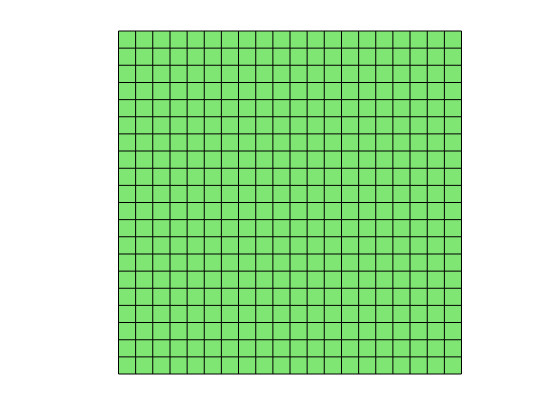

In [21]:
showmesh(node,elem);
hold on;
% add centers of special elements (two vertices on the interface)
%  0 - -1    -1 - 0     0 -  0      1 - 0
%  1 -  0     0 - 1     1 - -1      1 - 0
isSpecialElem = (sum(abs(vSign(elem)),2) <= 2); % two or more vertices on interfaces
% isSpecialElem = (sum(vSign(elem),2) == 0) & (sum(abs(vSign(elem)),2) == 2);
specialElem = elem(isSpecialElem,:);
auxPoint = (node(specialElem(:,1),:) + node(specialElem(:, 3),:))/2.0;
Naux = size(auxPoint,1);
vSign(N+Ncut+1:N+Ncut+Naux) = sign(phi(auxPoint));
% find the first two cases
isDiagInterface = (vSign(specialElem(:,1)).*vSign(specialElem(:,3)) == -1) | ...
                  (vSign(specialElem(:,2)).*vSign(specialElem(:,4)) == -1);
vSign(N+Ncut+find(isDiagInterface)) = 0;            
findnode(auxPoint,'all','noindex','color','m');

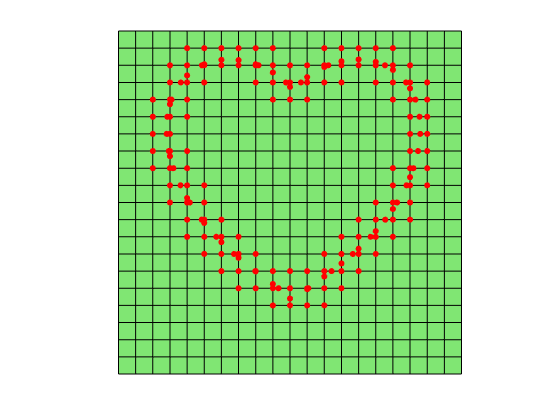

In [22]:
% add cut points and aux points
node = [node; cutNode; auxPoint];
nearInterfaceNode = [node(isInterfaceNode,:); cutNode; auxPoint];
interfaceNodeIdx = [find(isInterfaceNode); N+(1:Ncut)'; N+Ncut+(1:Naux)'];
showmesh(node,elem);
findnode(nearInterfaceNode,'all','noindex','color','r','MarkerSize',11);

## Construct a Delaunay triangulation on these points

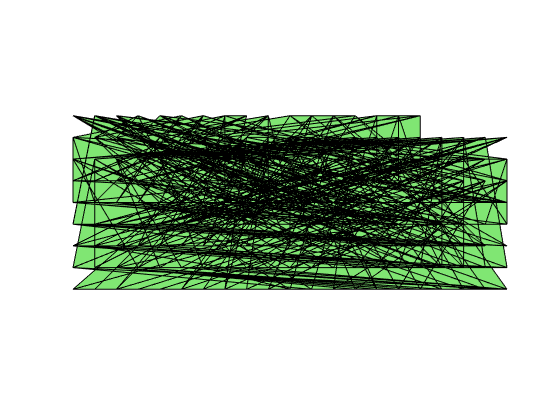

In [23]:
% construct the Delaunay triangulation of interfaceNode
% different versions of matlab using different delaunay triangulation
matlabversion = version();
if str2double(matlabversion(end-5:end-2)) <= 2013
    DT = DelaunayTri(nearInterfaceNode); %#ok<*DDELTRI>
    tElem = DT.Triangulation;
else
    DT = delaunayTriangulation(nearInterfaceNode);
    tElem = DT.ConnectivityList;
end
tElem = fixorder(nearInterfaceNode,tElem); % correct the orientation
showmesh(node,tElem);

The Delaunay triangulation is a mesh for the coonvex hull of the given points. Without postprocess, it is messy. 

## Post-processing

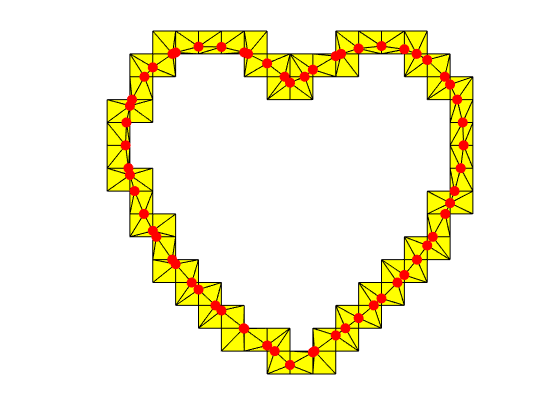

In [24]:
% get rid of the unnecessary triangles
NI = sum(isInterfaceNode);  % number of pts of the background mesh near interface
haveNewPts = (sum(tElem > NI,2) > 0); % triangles containing new added vertices
tElem = tElem(haveNewPts,:); 
tElem = interfaceNodeIdx(tElem);  % map interfaceNode index to node index
showmesh(node,tElem,'Facecolor','y');
findnode(node,vSign==0,'noindex');

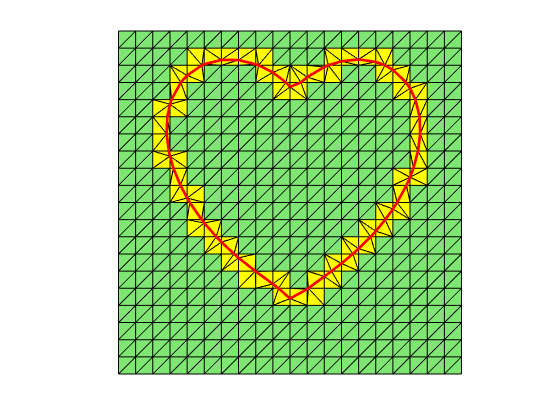

In [25]:
% get the remainding quad elems
sElem = elem(~isInterfaceElem,:);
% merge into one triangulation
elem = [tElem; sElem(:,[2 3 1]); sElem(:,[4 1 3])];
T = auxstructure(tElem);
showmesh(node,elem); hold on;
showmesh(node,tElem,'Facecolor','y');
isInterfaceEdge = ((vSign(T.edge(:,1)) == 0) & vSign(T.edge(:,2)) == 0);
interfaceEdge = T.edge(isInterfaceEdge,:);
nearInterfaceNode = find(vSign == 0);
findedge(node,interfaceEdge,'all','noindex','draw');

In [26]:
%% Generate interface data
interface.vSign = vSign;
interface.tElem = tElem;
interface.sElem = sElem;
interface.edge = interfaceEdge;
interface.node = nearInterfaceNode;